В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [ ]:
raw_df = pd.read_csv('train.csv')

train_df, val_df = split_train_val(raw_df, 'Exited')

cols = raw_df.columns.drop(['id', 'CustomerId', 'Surname'])

input_cols = [col for col in cols if col != 'Exited']
target_col = 'Exited'

In [ ]:
input_train, target_train = separate_inputs_targets(train_df, input_cols=input_cols, target_col = target_col)

input_val, target_val = separate_inputs_targets(val_df, input_cols=input_cols, target_col = target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [ ]:
input_train.info()

In [ ]:
cat_features = input_train.select_dtypes(include='object').columns
input_train[cat_features] = input_train[cat_features].astype('category')
input_val[cat_features] = input_val[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(input_train, target_train)

train_pred = xgb_clf.predict(input_train)
val_pred = xgb_clf.predict(input_val)

#AUROC
train_auc = roc_auc_score(target_train, train_pred)
val_auc = roc_auc_score(target_val, val_pred)

print(f"Train AUROC: {train_auc:.3f}")
print(f"Validation AUROC: {val_auc:.3f}")

Train AUROC: 0.806
Validation AUROC: 0.801


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:56:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ми отримали Train AUROC: 0.806 та Validation AUROC: 0.801, що є нормальним результатом. Якщо порівняти до ДЗ з KNN, то навіть краще, було Train AUROC: 0.810
Validation AUROC: 0.559

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )
    #AUROC
    clf.fit(
        input_train,
        target_train,
        eval_set=[(input_val, target_val)],
        verbose=False)
    pred = clf.predict(input_val)
    AUROC = roc_auc_score(target_val, pred)

    return {'loss': -AUROC, 'status': STATUS_OK}

    # Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 301, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}
# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(input_train, target_train)
final_pred = final_clf.predict(input_val)
final_AUROC = roc_auc_score(target_val, final_pred)
print("Точність на валідаційній вибірці: {:.4f}".format(final_AUROC))


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 10%|█         | 2/20 [00:00<00:03,  5.15trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 20%|██        | 4/20 [00:00<00:02,  5.42trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 30%|███       | 6/20 [00:01<00:02,  5.57trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 35%|███▌      | 7/20 [00:01<00:02,  5.69trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 40%|████      | 8/20 [00:01<00:03,  3.15trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 50%|█████     | 10/20 [00:02<00:02,  4.16trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 65%|██████▌   | 13/20 [00:02<00:01,  4.97trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 70%|███████   | 14/20 [00:02<00:01,  4.82trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 80%|████████  | 16/20 [00:03<00:00,  4.50trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 90%|█████████ | 18/20 [00:03<00:00,  4.68trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



 95%|█████████▌| 19/20 [00:03<00:00,  5.40trial/s, best loss: -0.8228719390904726]

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:34:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



100%|██████████| 20/20 [00:04<00:00,  4.71trial/s, best loss: -0.8228719390904726]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.8118223162427733), 'gamma': np.float64(0.388422717649506), 'learning_rate': np.float64(0.2584202062891782), 'max_depth': 19, 'min_child_weight': 10, 'n_estimators': 50, 'reg_alpha': np.float64(0.6260150821391605), 'reg_lambda': np.float64(0.9267902326503322), 'subsample': np.float64(0.6414800485137537)}
Точність на валідаційній вибірці: 0.8165


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:34:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Було  - Validation AUROC: 0.801
Стало - Validation AUROC: 0.816
Можна зробити висновок, що модель покращілась на валідаційних даних.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [ ]:
cat_feature_indexes = [input_train.columns.get_loc(col) for col in cat_features]

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth = 6,
    n_estimators = 20,
    learning_rate = 0.1,
    cat_feature = cat_feature_indexes,
    enable_categorical = True,
    use_label_encoder = False,
    missing = np.nan
)
lgb_clf.fit(input_train, target_train, eval_set = [(input_val, target_val)])
train_pred = lgb_clf.predict_proba(input_train)[:,1]
val_pred = lgb_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, train_pred), roc_auc_score(target_val, val_pred)

[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: u

(np.float64(0.9428239016280446), np.float64(0.9345037382536525))

Показники тільки покращілись, як тренувальні так і валідаційні. Якість однозначно покращилась!

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        cat_feature=cat_feature_indexes,
    )
    clf.fit(
        input_train,
        target_train,
        eval_set=[(input_val, target_val)])
    pred = clf.predict_proba(input_val)[:,1]
    roc_auc = roc_auc_score(target_val, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
  }

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])
print("Найкращі гіперпараметри: ", best)

final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    categorical_feature=cat_feature_indexes,
    missing=np.nan,
    eval_metric='auc'
)

final_clf.fit(input_train, target_train, eval_set=[(input_val, target_val)], eval_metric='auc')
final_pred_train = final_clf.predict_proba(input_train)[:,1]
final_pred_val = final_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, final_pred_train), roc_auc_score(target_val, final_pred_val)

[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

(np.float64(0.9478828683160131), np.float64(0.9363701214075039))

модель знову ж таки покращилась, зовсім трохи на 0,02 але все таки прогрес є

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df = test_df.drop(['id', 'CustomerId', 'Surname'], axis = 1)

In [ ]:
test_df[cat_features] = test_df[cat_features].astype('category')

In [ ]:
test_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [ ]:
test_pred = final_clf.predict_proba(test_df)[:, 1]

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: missing


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submission['Exited'] = test_pred

In [ ]:
sample_submission.to_csv('submission_LightGBM.csv', index=False)

Для submission на Kaggle я обрала LightGBM


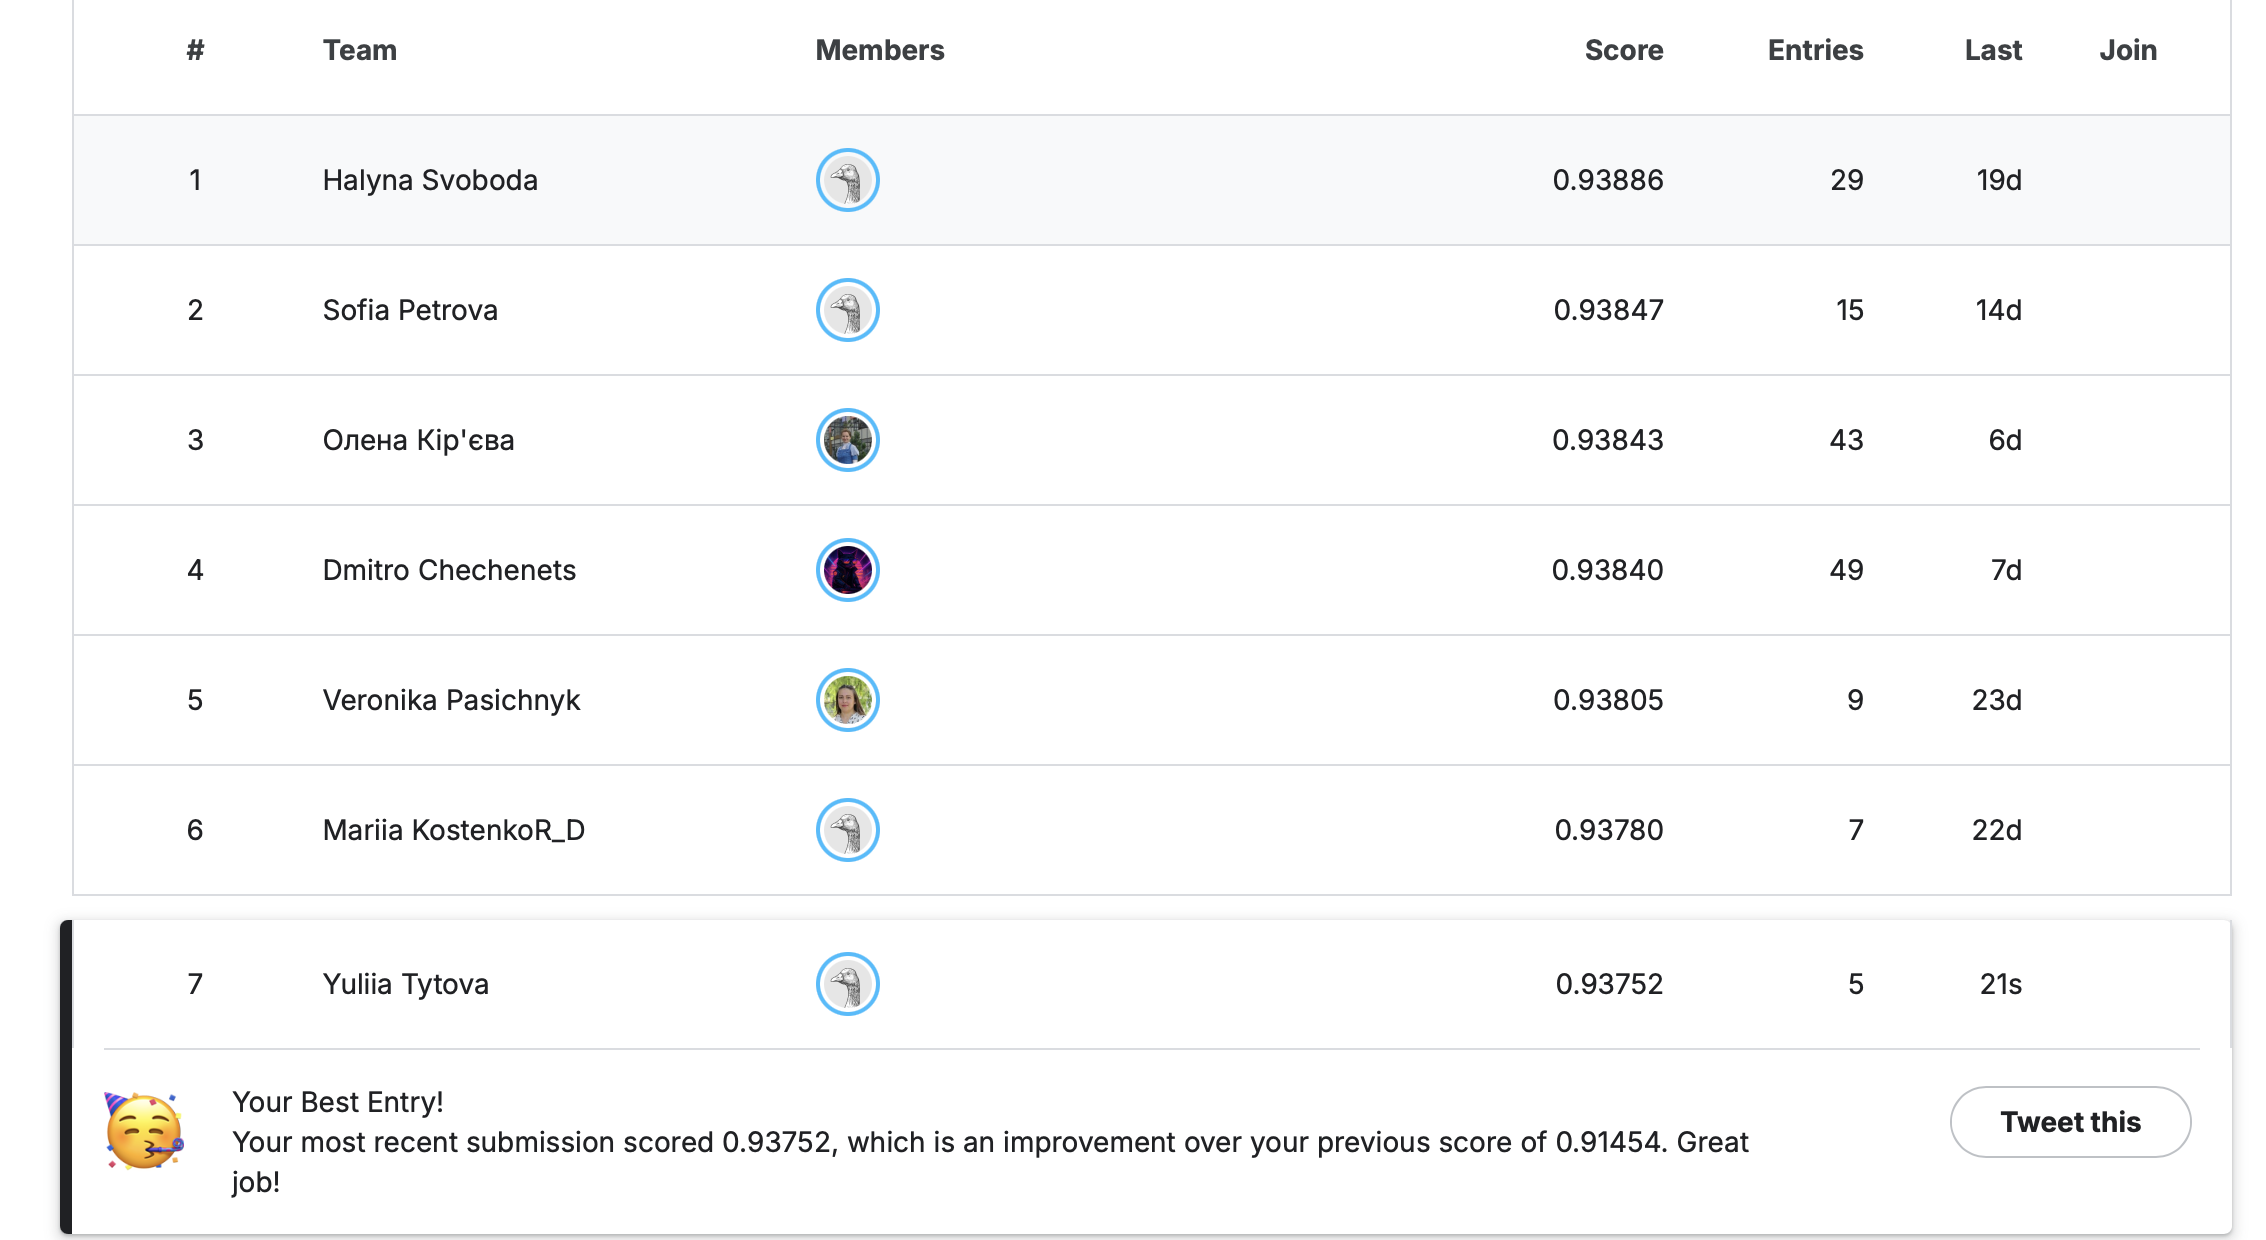